#### Clear Ram

In [1]:
import gc

In [2]:
gc.collect()

215

#### Load Libraries

In [3]:
import mne
import numpy as np
import pandas 
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import math
import pywt

from utils import *
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA

random.seed(444)

### Load & Process Data

#### Define Data Paths

In [4]:
main_path = '/home/Desktop/FINAL DATASET ~ 22nd Sep/'
ab_edf_path = main_path + 'EDF Files/Abnormal EDF Files/'
n_edf_path = main_path + 'EDF Files/Normal EDF Files/'
ab_labels_path = main_path + 'CSV Files/SW & SSW CSV Files/'
save_path = '/home/Downloads/FYP - Notebooks/data/numpy arrays/'

In [5]:
class_label_names = ['normal', 'slowing', 'spike and wave']

#### Load Data from File

In [6]:
all_edf_data = np.concatenate((os.listdir(n_edf_path),os.listdir(ab_edf_path)), axis = 0)

In [7]:
# Line position for train and test

train_pos = 0
valid_pos = 501325
test_pos = 608753

In [11]:
w = pywt.Wavelet('db2')

In [ ]:
train_window_data = []
train_window_labels = []

test_window_data = []
test_window_labels = []

normal_count = 0
slowing_count = 0
spike_count = 0

for edf_name in tqdm(all_edf_data):
    file_num = int(edf_name[:-4])
    
    if edf_name in os.listdir(ab_edf_path):
        edf_path = ab_edf_path
    else:
        edf_path = n_edf_path
    
    raw = mne.io.read_raw_edf(edf_path+edf_name,preload = True,exclude = ['A1','A2'])     # Importing all EEG Channels, exculding A1 A2 since matlab has already refrenced the channels with A1 and A2
    raw.filter(l_freq=1,h_freq=45)      # Bandpass filtering [1-45] Hz
    epochs=mne.make_fixed_length_epochs(raw,duration=2,overlap=1)
    epochs_data=epochs.get_data()
    
    data = np.array(raw.get_data()[0:19])
    print('epochs_data shape = ',epochs_data.shape)
    
    # Epochs_data = np.concatenate((Epochs_data, epochs_data), axis=0)

    with open('/home/Downloads/FYP - Notebooks/window_tracker.txt', 'r') as f:
        lines = f.readlines()
        for single_line in lines[train_pos+1:valid_pos]:
            single_line_list = single_line.split(' ')
            if edf_name == single_line_list[0]:
                
                data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                pca = PCA(n_components = 2)
                decomp_levels = pywt.wavedec(data, wavelet=w,level = 4)
                feature_vector = []
                for k in range(len(decomp_levels)):
                    feature_vector.append(stat_features(decomp_levels[k]))
                feature_vector = np.array(feature_vector)
                pca.fit(feature_vector)
                pca_features = pca.fit_transform(feature_vector)
                train_window_data.append(np.array(pca_features.flatten()))

                train_window_labels.append(np.array(int(single_line_list[3])))
        
        for single_line in lines[valid_pos+1:test_pos]:
            single_line_list = single_line.split(' ')
            if edf_name == single_line_list[0]:
                
                data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                pca = PCA(n_components = 2)
                decomp_levels = pywt.wavedec(data, wavelet=w,level = 4)
                feature_vector = []
                for k in range(len(decomp_levels)):
                    feature_vector.append(stat_features(decomp_levels[k]))
                feature_vector = np.array(feature_vector)
                pca.fit(feature_vector)
                pca_features = pca.fit_transform(feature_vector)
                train_window_data.append(np.array(pca_features.flatten()))

                train_window_labels.append(np.array(int(single_line_list[3])))
        
        for single_line in lines[test_pos+1:]:
            single_line_list = single_line.split(' ')
            if edf_name == single_line_list[0]:
                
                data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                pca = PCA(n_components = 2)
                decomp_levels = pywt.wavedec(data, wavelet=w,level = 4)
                feature_vector = []
                for k in range(len(decomp_levels)):
                    feature_vector.append(stat_features(decomp_levels[k]))
                feature_vector = np.array(feature_vector)
                pca.fit(feature_vector)
                pca_features = pca.fit_transform(feature_vector)
                test_window_data.append(np.array(pca_features.flatten()))

                test_window_labels.append(np.array(int(single_line_list[3])))

    

In [20]:
# Save
np.save(save_path + 'X_train.npy', train_window_data)
np.save(save_path + 'X_test.npy', test_window_data)

np.save(save_path + 'y_train.npy', train_window_labels)
np.save(save_path + 'y_test.npy', test_window_labels)

In [12]:
gc.collect

<function gc.collect(generation=2)>

In [8]:
X_train = np.load(save_path + 'X_train.npy')
y_train = np.load(save_path + 'y_train.npy')

X_test = np.load(save_path + 'X_test.npy')
y_test = np.load(save_path + 'y_test.npy')

In [9]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(608749, 10)
(608749,)
(107426, 10)
(107426,)


#### Standardize Data

In [21]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [22]:
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

### Model Implementation

#### Accuracy Metrics and Confusion Matrix

In [12]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

In [13]:
def plot_confusion_matrix(cm, classes = [0, 1, 2],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.rcParams['figure.dpi'] = 150

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
def print_score(clf, X_train, y_train, X_test, y_test, train = True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train), digits=5)))
        cm = confusion_matrix(y_train, clf.predict(X_train))
        plot_confusion_matrix(cm)
        
    elif train == False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test), digits=5)))
        cm = confusion_matrix(y_test, clf.predict(X_test))
        plot_confusion_matrix(cm)

#### Model 1: Simple Decision Tree Classifier

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [162]:
cart_clf = DecisionTreeClassifier(criterion='entropy',max_features = 'log2',random_state = 0,max_depth=5,min_samples_leaf=50,splitter = 'best')

In [163]:
cart_clf.fit(X_train_sc, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       min_samples_leaf=50, random_state=0)

In [164]:
#print_score(cart_clf, X_train_sc, y_train, X_test_sc, y_test, train = True)

Test Result:

accuracy score: 0.7193

Classification Report: 
               precision    recall  f1-score   support

           0    0.82836   0.86999   0.84866     65409
           1    0.51264   0.54008   0.52600     23878
           2    0.55002   0.41160   0.47085     18139

    accuracy                        0.71926    107426
   macro avg    0.63034   0.60722   0.61517    107426
weighted avg    0.71119   0.71926   0.71315    107426


Confusion matrix, without normalization
[[56905  5655  2849]
 [ 7723 12896  3259]
 [ 4068  6605  7466]]


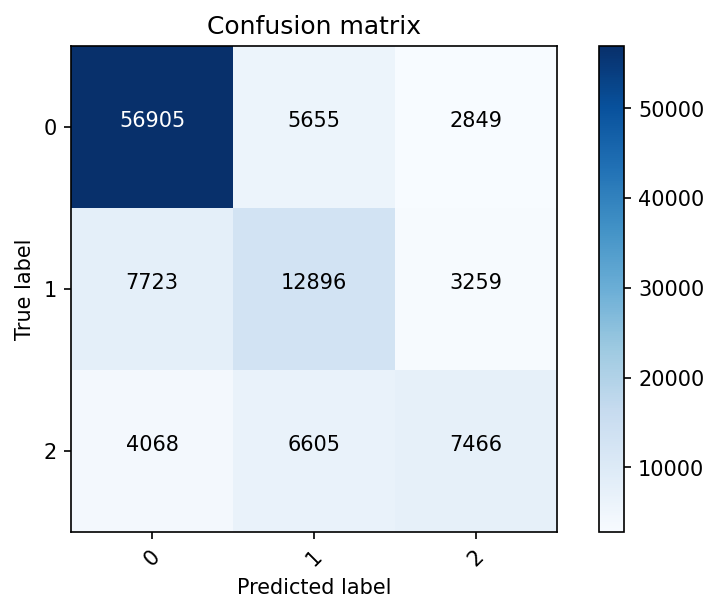

In [165]:
print_score(cart_clf, X_train_sc, y_train, X_test_sc, y_test, train = False)

#### Model 2: Random Forest Classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [213]:
rf_clf = RandomForestClassifier(n_estimators = 50,criterion='entropy',max_features = 'sqrt',random_state = 0,max_depth=6,min_samples_leaf=10)
rf_clf.fit(X_train_sc, y_train.ravel())

RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       min_samples_leaf=10, n_estimators=50, random_state=0)

In [ ]:
print_score(rf_clf, X_train_sc, y_train, X_test_sc, y_test, train = True)

Test Result:

accuracy score: 0.7445

Classification Report: 
               precision    recall  f1-score   support

           0    0.85178   0.86355   0.85762     65409
           1    0.57906   0.56931   0.57414     23878
           2    0.56155   0.54601   0.55367     18139

    accuracy                        0.74453    107426
   macro avg    0.66413   0.65962   0.66181    107426
weighted avg    0.74215   0.74453   0.74329    107426


Confusion matrix, without normalization
[[56484  5462  3463]
 [ 6014 13594  4270]
 [ 3815  4420  9904]]


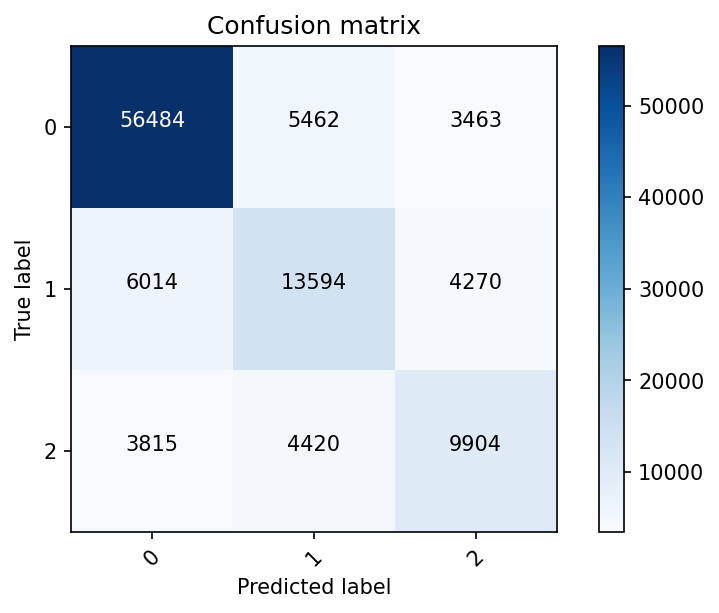

In [214]:
print_score(rf_clf, X_train_sc, y_train, X_test_sc, y_test, train = False)                                     

#### Model 3: Linear SVM

In [23]:
from sklearn import svm

In [24]:
svm_clf = svm.SVC(kernel='linear',decision_function_shape = 'ovo',gamma='auto',random_state=0, C = 3.0,verbose=True)
svm_clf.fit(X_train_sc, y_train)

[LibSVM]............................................................................................................................
*...
*....
*....
*..
*.
*..
*
optimization finished, #iter = 139119
obj = -637626.143061, rho = 8.037256
nSV = 213388, nBSV = 213363
.............................................................................................
*.....
*.
*.
*.
*
optimization finished, #iter = 99878
obj = -479342.764070, rho = 0.324479
nSV = 159878, nBSV = 159844
.........................................................................................
*..
*........
*.....
*....
*..
*..
*..
*.
*.
*
optimization finished, #iter = 113928
obj = -462065.347084, rho = -9.708800
nSV = 156061, nBSV = 156043
Total nSV = 337566


SVC(C=3.0, decision_function_shape='ovo', gamma='auto', kernel='linear',
    random_state=0, verbose=True)

Test Result:

accuracy score: 0.7214

Classification Report: 
               precision    recall  f1-score   support

           0    0.76472   0.91712   0.83402     65409
           1    0.59204   0.42901   0.49751     23878
           2    0.62163   0.40024   0.48695     18139

    accuracy                        0.72135    107426
   macro avg    0.65946   0.58213   0.60616    107426
weighted avg    0.70218   0.72135   0.70062    107426


Confusion matrix, without normalization
[[59988  3405  2016]
 [11231 10244  2403]
 [ 7225  3654  7260]]


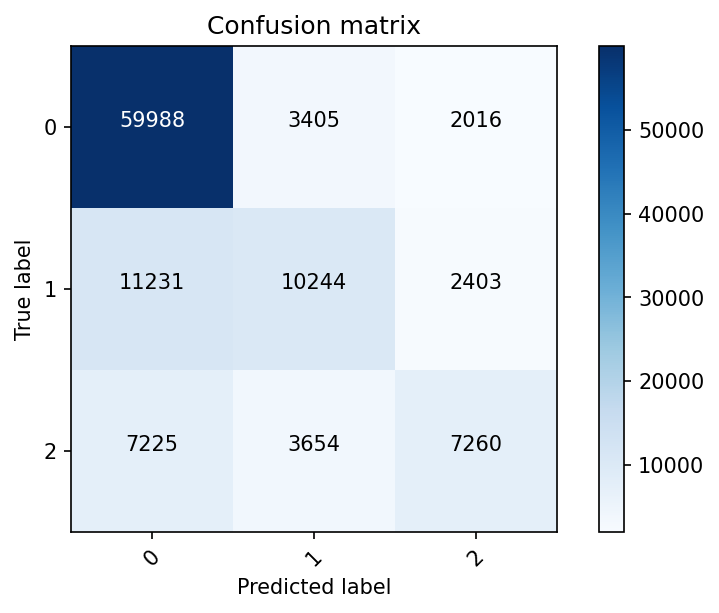

In [25]:
print_score(svm_clf, X_train_sc, y_train, X_test_sc, y_test, train = False)

END

**Signed By:**

Muiz Alvi

Adil Jowad Qureshi